## Using a PINN to solve a simple ODE without any data (other than initial condtition)
ODE:  $dy/dt = -y$

Initial condition: $y=2$

#### ODE Definition

In [6]:
def dydt(y,t):
    return -y

y0 = 2 # Initial condition

Text(0.5, 1.0, 'True solution')

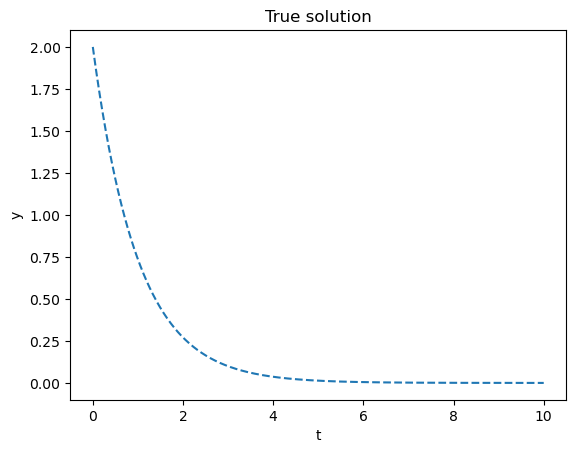

In [7]:
# True solution:
# (of course, the true solution is y(t)=2*exp(-t), but I'm using scipy's odeint so I can
#  easily generalize to more complicated ODEs.)

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

ts = np.linspace(0,10,1000)
ys = odeint(dydt,y0,ts)

plt.plot(ts,ys,'--')
plt.xlabel('t')
plt.ylabel('y')
plt.title('True solution')

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
    nn.Linear(1, 20),
    nn.GELU(),
    nn.Linear(20, 20),
    nn.GELU(),
    nn.Linear(20, 1),
)

ts_test = np.linspace(0,5,100)
ts_test_with_grad = torch.tensor(ts_test, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
def ODE_loss(model):
    ys_model = model(ts_test_with_grad)
    dydt_model = torch.autograd.grad(outputs=ys_model, inputs=ts_test_with_grad, 
                                     grad_outputs=torch.ones_like(ys_model), create_graph=True)[0]
    dydt_true = dydt(ys_model,ts_test)
    return torch.mean((dydt_true - dydt_model)**2)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initial time:
t0 = torch.tensor([[ts_test[0]]], dtype=torch.float32)

In [9]:
N_EPOCHS = 5000
for epoch in range(N_EPOCHS):
    # Loss is ODE_loss + Initial condition loss
    loss = ODE_loss(model) + (model(t0) - y0)**2

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch%100 == 0:
        print('epoch:',epoch,"  loss=",loss.item())

epoch: 0   loss= 4.303833961486816
epoch: 100   loss= 0.7742539048194885
epoch: 200   loss= 0.01392593327909708
epoch: 300   loss= 0.00422409363090992
epoch: 400   loss= 0.002002937253564596
epoch: 500   loss= 0.0014035108033567667
epoch: 600   loss= 0.001168613089248538
epoch: 700   loss= 0.0010390321258455515
epoch: 800   loss= 0.0009445666801184416
epoch: 900   loss= 0.0008632835233584046
epoch: 1000   loss= 0.0007878813776187599
epoch: 1100   loss= 0.0007154924678616226
epoch: 1200   loss= 0.0006449039792641997
epoch: 1300   loss= 0.0005759228952229023
epoch: 1400   loss= 0.0005091414786875248
epoch: 1500   loss= 0.0004456578171811998
epoch: 1600   loss= 0.00038677596603520215
epoch: 1700   loss= 0.00033374715712852776
epoch: 1800   loss= 0.0002874723286367953
epoch: 1900   loss= 0.00024828652385622263
epoch: 2000   loss= 0.00021593259589280933
epoch: 2100   loss= 0.0001896914473036304
epoch: 2200   loss= 0.00016859320749063045
epoch: 2300   loss= 0.00015160634939093143
epoch: 2400

(-2.0, 10.0)

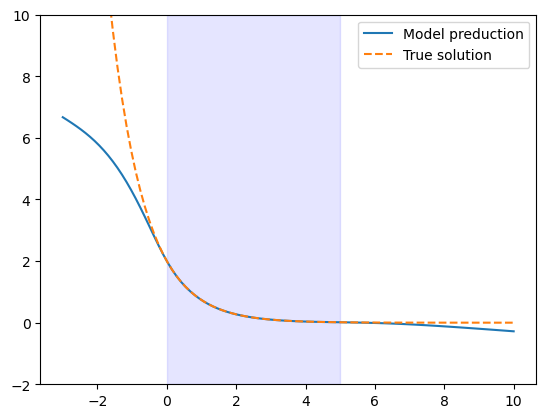

In [10]:
ts_test = np.linspace(-3,10,100)
ts_test_torch = torch.tensor(ts_test, dtype=torch.float32).reshape(-1, 1)
ys_model = model(ts_test_torch).detach().cpu().numpy()
plt.plot(ts_test,ys_model)
plt.plot(ts_test,2*np.exp(-ts_test),'--')
plt.legend(['Model preduction','True solution'])
plt.axvspan(0, 5, color='blue', alpha=0.1)
plt.ylim(-2,10)

In the above plot, the shaded region indicates where the PINN's ODE_loss was evaluated.
The model is a great approximation within this region, but it doesn't generalize very
well outside of this region.